## import library

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')
import zipfile
from tensorflow.keras.callbacks import ModelCheckpoint

## read datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Bangkit/datasets_image/datasets.zip'
extract_path = '/content/datasets'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
image_data = '/content/datasets/dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,metal
1,plastic
2,glass
3,paper
4,cardboard
5,organic


In [ ]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/content/datasets/dataset/plastic/IMG_20200415...,plastic
1,/content/datasets/dataset/cardboard/cardboard2...,cardboard
2,/content/datasets/dataset/paper/R_3167.jpg,paper
3,/content/datasets/dataset/metal/R_2082.jpg,metal
4,/content/datasets/dataset/cardboard/Real_Cardb...,cardboard
...,...,...
5995,/content/datasets/dataset/paper/R_6666.jpg,paper
5996,/content/datasets/dataset/paper/R_3175.jpg,paper
5997,/content/datasets/dataset/cardboard/Real_Cardb...,cardboard
5998,/content/datasets/dataset/paper/R_2932.jpg,paper


## split data

In [ ]:
train_data_dir =image_data
batch_size = 128                           # de 32 para 128
target_size = (224,224)
validation_split = 0.2

In [ ]:
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                                                         # de 100 para 50
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                                                         # de 200 para 100
    image_size=target_size,
    batch_size=batch_size,
)

Found 6000 files belonging to 6 classes.
Using 4800 files for training.
Found 6000 files belonging to 6 classes.
Using 1200 files for validation.


In [ ]:
class_names = train.class_names
class_names

['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic']

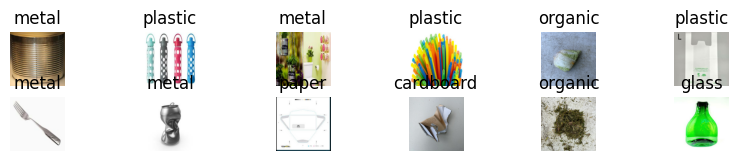

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(12, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## modeling

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B1(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(6,activation=tf.nn.softmax))
keras_model.summary()

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)       │ (None, 7, 7, 1280)          │       6,931,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │         376,326 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,307,450 (27.88 MB)

 Trainable params: 376,326 (1.44 MB)

 Non-trainable params: 6,931,124 (26.44 MB)

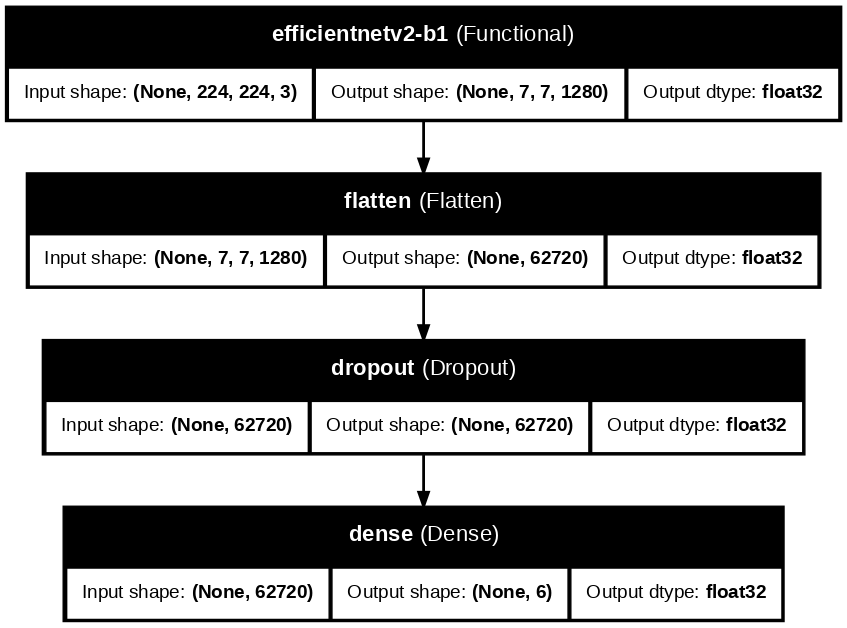

In [ ]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=100)

In [ ]:
checkpoint = ModelCheckpoint("my_keras_model.keras", save_best_only=True)

In [ ]:
early_stopping =EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = keras_model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 703s 18s/step - accuracy: 0.7338 - loss: 1.1077 - val_accuracy: 0.9667 - val_loss: 0.1523
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 713s 17s/step - accuracy: 0.9633 - loss: 0.1588 - val_accuracy: 0.9783 - val_loss: 0.1037
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 691s 18s/step - accuracy: 0.9735 - loss: 0.1026 - val_accuracy: 0.9767 - val_loss: 0.1408
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 671s 17s/step - accuracy: 0.9822 - loss: 0.0602 - val_accuracy: 0.9825 - val_loss: 0.1116
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 682s 17s/step - accuracy: 0.9865 - loss: 0.0483 - val_accuracy: 0.9800 - val_loss: 0.1116
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 663s 17s/step - accuracy: 0.9856 - loss: 0.0498 - val_accuracy: 0.9808 - val_loss: 0.1058
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 701s 17s/step - accuracy: 0.9879 - loss: 0.0549 - val_accuracy: 0.9817 - val_loss: 0.1239
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 651s 17s/step - accuracy: 0.9916 - loss: 0.0417 - val_accuracy: 0.

In [ ]:
keras_model.save("my_model.h5")

In [ ]:
# Menyimpan model dalam format SavedModel
keras_model.export("saved_model_directory")

Saved artifact at 'saved_model_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_334')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  132600406781344: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132600407011952: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132600588902544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132600406773424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132600406772720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132600406778880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132600406780112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132600406778000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132600407505232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132600406772016: TensorSpec(shape=(), dtype=tf.resource, 

In [ ]:
import shutil
shutil.copytree('/content/saved_model_directory', '/content/drive/MyDrive/saved_model_directory')

'/content/drive/MyDrive/saved_model_directory'

In [ ]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 11s/step - accuracy: 0.9799 - loss: 0.1553
Test Loss = 0.12154673039913177
Test Accuracy = 0.9808333516120911


## visualization

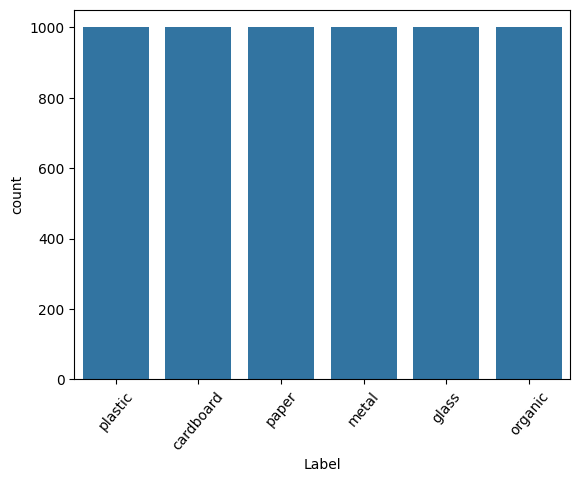

In [ ]:
sns.countplot(x = dataframe["Label"])
plotter.xticks(rotation = 50);

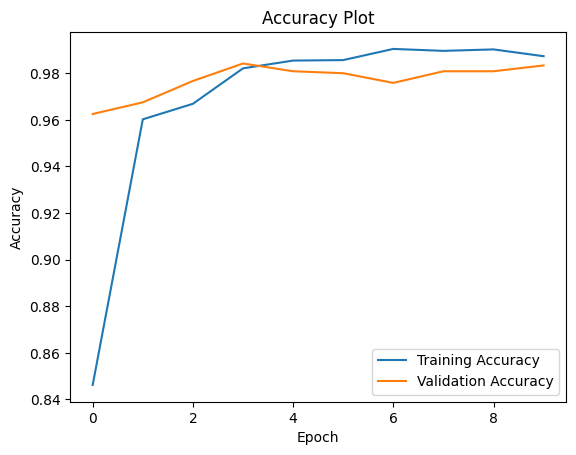

In [ ]:
# Mengakses data dari hist.history
accuracy = hist.history['accuracy']            # Training Accuracy
val_accuracy = hist.history['val_accuracy']    # Validation Accuracy

# Membuat plot akurasi
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

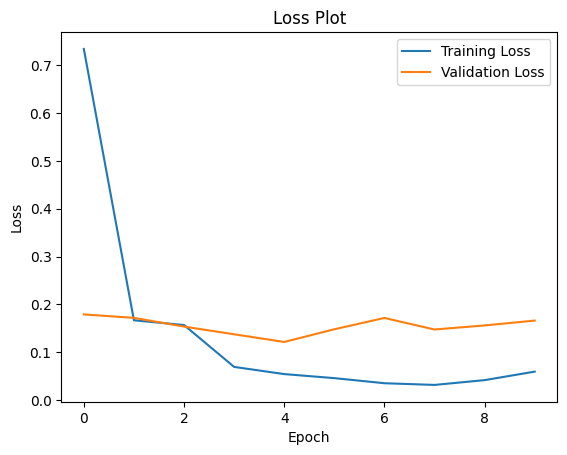

In [ ]:
# Loss train & validation
plt.plot(hist.history['loss'], label='Training Loss')          # Ambil data loss dari objek hist
plt.plot(hist.history['val_loss'], label='Validation Loss')    # Ambil data val_loss dari objek hist
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Saving coba.jpg to coba.jpg
File yang diunggah: coba.jpg


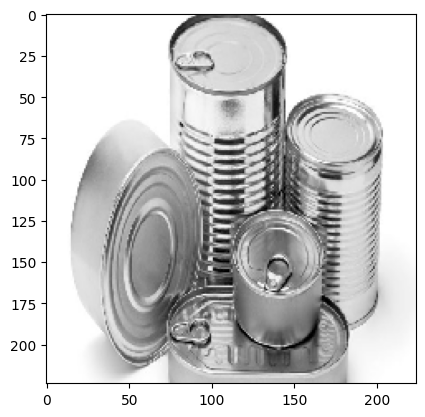

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
File: coba.jpg
Prediksi: metal


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Pastikan diimpor
import matplotlib.pyplot as plt



class_labels = ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic']
# Mengunggah file
uploaded = files.upload()

# Memproses setiap file yang diunggah
for fn in uploaded.keys():
    print(f"File yang diunggah: {fn}")
    path = fn

    # Memuat gambar dan mengubah ukurannya sesuai dengan input model
    img = load_img(path, target_size=(224, 224))  # Sesuaikan target_size dengan input model Anda
    imgplot = plt.imshow(img)
    plt.show()  # Menampilkan gambar yang diunggah

    # Mengonversi gambar ke array
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Melakukan prediksi menggunakan model
    predictions = keras_model.predict(x)  # Pastikan keras_model sudah terdefinisi
    predicted_index = np.argmax(predictions)  # Mendapatkan indeks dengan probabilitas tertinggi
    predicted_label = class_labels[predicted_index]  # Mendapatkan nama kategori berdasarkan indeks

    # Menampilkan hasil prediksi
    print("==========================================")
    print(f"File: {fn}")
    print(f"Prediksi: {predicted_label}")
    print("==========================================")

In [ ]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step


,Actual,Prediction
0,0,0
1,5,5
2,4,4
3,5,5
4,4,4
...,...,...
1195,3,3
1196,1,1
1197,1,1
1198,2,2


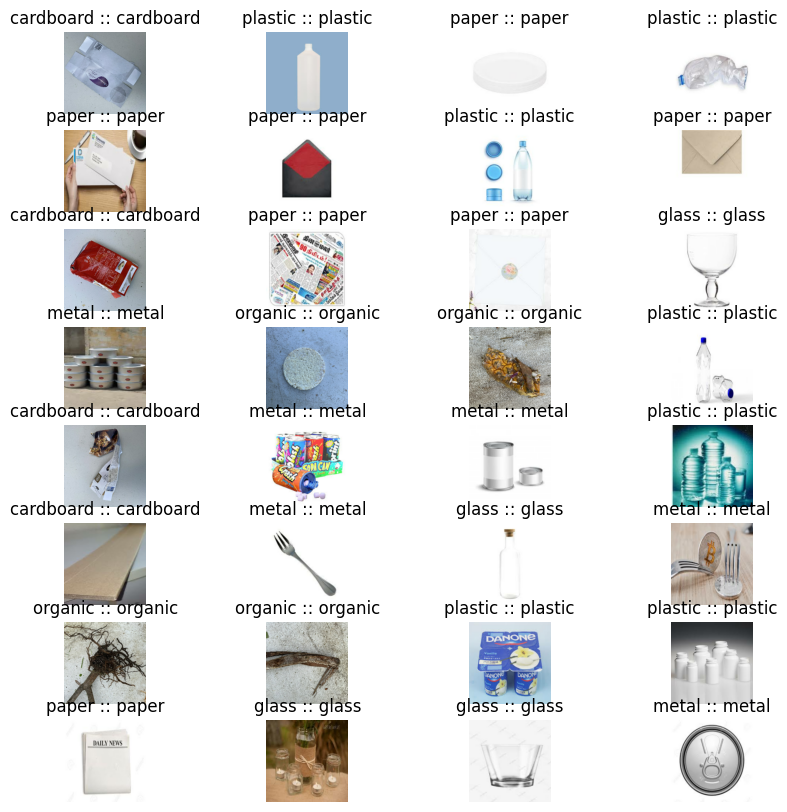

In [ ]:
plt.figure(figsize=(10,10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

## pre-deployment


In [ ]:
zip_path = '/content/saved_model.zip'
extract_path = '/content/saved_model'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_format=tfjs_graph_model \
                        /content/saved_model/saved_model \
                        /content/tfjs_model


2024-12-07 08:07:35.520700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733558855.565610    2799 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733558855.582508    2799 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 08:07:35.626326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-1

In [ ]:
import shutil
from google.colab import files

# Kompres folder tfjs_model
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')

# Unduh file zip
files.download('/content/tfjs_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>